<a href="https://colab.research.google.com/github/debojit11/Review-Detector/blob/main/training1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mexwell/fake-reviews-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.78M/4.78M [00:00<00:00, 55.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mexwell/fake-reviews-dataset/versions/1


In [ ]:
# Move the entire dataset folder to /content
!mv "/root/.cache/kagglehub/datasets/mexwell/fake-reviews-dataset/versions/1" "/content/fake_reviews_dataset"

In [ ]:
!ls

fake_reviews_dataset  sample_data


In [ ]:
!ls -lh fake_reviews_dataset

total 15M
-rw-r--r-- 1 root root 15M Apr 12 11:55 'fake reviews dataset.csv'


In [ ]:
!mv "/content/fake_reviews_dataset/fake reviews dataset.csv" "/content/dataset.csv"

In [ ]:
!ls -lh /content

total 15M
-rw-r--r-- 1 root root  15M Apr 12 11:55 dataset.csv
drwxr-xr-x 2 root root 4.0K Apr 12 11:55 fake_reviews_dataset
drwxr-xr-x 1 root root 4.0K Apr 10 13:37 sample_data


In [ ]:
!rmdir "/content/fake_reviews_dataset"

In [ ]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from accelerate import Accelerator

In [ ]:
df = pd.read_csv('dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [ ]:
df['label'] = df['label'].map({'CG': 1, 'OR': 0})

In [ ]:
df.head(10)

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,1,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,1,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,1,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,1,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,1,Very nice set. Good quality. We have had the s...
5,Home_and_Kitchen_5,3.0,1,I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.
6,Home_and_Kitchen_5,5.0,1,They are the perfect touch for me and the only...
7,Home_and_Kitchen_5,3.0,1,These done fit well and look great. I love th...
8,Home_and_Kitchen_5,5.0,1,"Great big numbers & easy to read, the only thi..."
9,Home_and_Kitchen_5,5.0,1,My son loves this comforter and it is very wel...


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
class ReviewDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    encoding = self.tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        padding = 'max_length',
        truncation = True,
        return_tensors = 'pt'
    )
    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(self.labels[idx], dtype=torch.long)
    }

In [ ]:
train_dataset = ReviewDataset(train_df['text_'].values, train_df['label'].values, tokenizer)
test_dataset = ReviewDataset(test_df['text_'].values, test_df['label'].values, tokenizer)

In [ ]:
accelerator = Accelerator(mixed_precision='fp16')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model = torch.quantization.quantize_dynamic(
#     model, {torch.nn.Linear}, dtype=torch.qint8
# )

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

In [ ]:
model, optimizer, train_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, test_loader)

In [ ]:
for epoch in range(3):  # 3 epochs is enough for fine-tuning
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        with accelerator.accumulate(model):
            # Explicitly separate inputs and labels
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['label']  # Pass labels separately
            )
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.0063
Epoch 2 | Loss: 0.0106
Epoch 3 | Loss: 0.0005


In [ ]:
model.eval()
predictions, true_labels = [], []

for batch in test_loader:
    with torch.no_grad():
        # Explicitly pass only the expected arguments
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
    preds = torch.argmax(outputs.logits, dim=1)

    # Gather across processes if distributed
    preds, labels = accelerator.gather_for_metrics((preds, batch['label']))
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      4044
        Fake       0.99      0.98      0.99      4043

    accuracy                           0.99      8087
   macro avg       0.99      0.99      0.99      8087
weighted avg       0.99      0.99      0.99      8087



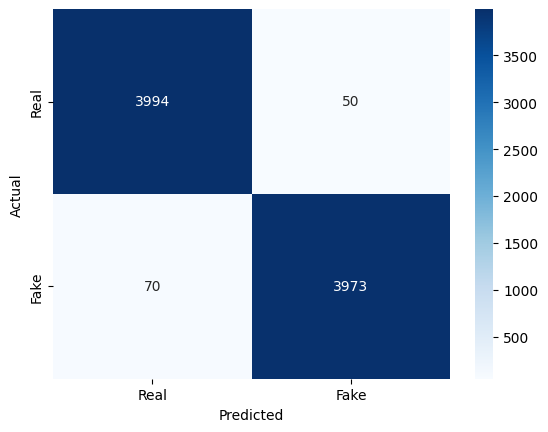

In [ ]:
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Real', 'Fake'],
               yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
model.save_pretrained("fake_review_detector")

In [ ]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json')

In [ ]:
!ls -lh tokenizer/

total 236K
-rw-r--r-- 1 root root  125 Apr 12 12:04 special_tokens_map.json
-rw-r--r-- 1 root root 1.3K Apr 12 12:04 tokenizer_config.json
-rw-r--r-- 1 root root 227K Apr 12 12:04 vocab.txt


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("fake_review_detector")
model.save_pretrained("fake_review_detector", safe_serialization=False)

In [ ]:
!ls -lh fake_review_detector/

total 511M
-rw-r--r-- 1 root root  569 Apr 12 12:04 config.json
-rw-r--r-- 1 root root 256M Apr 12 12:04 model.safetensors
-rw-r--r-- 1 root root 256M Apr 12 12:04 pytorch_model.bin


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [ ]:
!git config --global credential.helper store

In [ ]:
!ls

dataset.csv  fake_review_detector  sample_data	tokenizer


In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("fake_review_detector")

In [ ]:
model.push_to_hub(
    "debojit01/fake_review_detector",
    private=False,  # This makes it public immediately
    commit_message="Initial public release",
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/debojit01/fake_review_detector/commit/28fdbd05d11c0e2d76bfa786987cb7d27e5a9b78', commit_message='Initial public release', commit_description='', oid='28fdbd05d11c0e2d76bfa786987cb7d27e5a9b78', pr_url=None, repo_url=RepoUrl('https://huggingface.co/debojit01/fake_review_detector', endpoint='https://huggingface.co', repo_type='model', repo_id='debojit01/fake_review_detector'), pr_revision=None, pr_num=None)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
tokenizer.push_to_hub(
    "debojit01/fake-review-detector",  # Same repo name
    commit_message="Add tokenizer",
    private=False
)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/debojit01/fake-review-detector/commit/8af627b74d52fcf40be3dcc742aeee9bc2587b19', commit_message='Add tokenizer', commit_description='', oid='8af627b74d52fcf40be3dcc742aeee9bc2587b19', pr_url=None, repo_url=RepoUrl('https://huggingface.co/debojit01/fake-review-detector', endpoint='https://huggingface.co', repo_type='model', repo_id='debojit01/fake-review-detector'), pr_revision=None, pr_num=None)

In [ ]:
model.save_pretrained("fake-review-detector-safetensors", safe_serialization=True)

In [ ]:
import os
src = "fake-review-detector-safetensors/model.safetensors"
dst_dir = "fake-review-detector"
dst = os.path.join(dst_dir, "model.safetensors")

In [ ]:
os.makedirs(dst_dir, exist_ok=True)

# Copy safetensors file
shutil.copyfile(src, dst)
print("model.safetensors copied successfully.")

model.safetensors copied successfully.


In [ ]:
model.push_to_hub(
    "debojit01/fake-review-detector",
    commit_message="Upload both PyTorch and safetensors formats",
    private=False
)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/debojit01/fake-review-detector/commit/8af627b74d52fcf40be3dcc742aeee9bc2587b19', commit_message='Upload both PyTorch and safetensors formats', commit_description='', oid='8af627b74d52fcf40be3dcc742aeee9bc2587b19', pr_url=None, repo_url=RepoUrl('https://huggingface.co/debojit01/fake-review-detector', endpoint='https://huggingface.co', repo_type='model', repo_id='debojit01/fake-review-detector'), pr_revision=None, pr_num=None)

In [ ]:
!ls -lh fake_review_detector/

total 511M
-rw-r--r-- 1 root root  569 Apr 12 12:04 config.json
-rw-r--r-- 1 root root 256M Apr 12 12:04 model.safetensors
-rw-r--r-- 1 root root 256M Apr 12 12:04 pytorch_model.bin


In [ ]:
from huggingface_hub import upload_file

upload_file(
    path_or_fileobj="fake_review_detector/pytorch_model.bin",  # ✅ corrected path
    path_in_repo="pytorch_model.bin",
    repo_id="debojit01/fake-review-detector",
    repo_type="model",
    commit_message="Manually upload pytorch_model.bin"
)

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/debojit01/fake-review-detector/commit/b41c8de92318d8f86eb9452b515c482c19ce963e', commit_message='Manually upload pytorch_model.bin', commit_description='', oid='b41c8de92318d8f86eb9452b515c482c19ce963e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/debojit01/fake-review-detector', endpoint='https://huggingface.co', repo_type='model', repo_id='debojit01/fake-review-detector'), pr_revision=None, pr_num=None)

In [ ]:
from huggingface_hub import create_repo

create_repo(
    repo_id="debojit01/fake-review-dataset",  # You can change this name if you want
    repo_type="dataset",
    private=False  # Set to True if you want it private
)

RepoUrl('https://huggingface.co/datasets/debojit01/fake-review-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='debojit01/fake-review-dataset')

In [ ]:
upload_file(
    path_or_fileobj="dataset.csv",  # ⬅️ replace with actual filename
    path_in_repo="fake_reviews.csv",  # How it will appear in the repo
    repo_id="debojit01/fake-review-dataset",
    repo_type="dataset",
    commit_message="Initial upload of fake review dataset CSV"
)

dataset.csv:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/debojit01/fake-review-dataset/commit/4411e330ac87d7ac0cb33307ed7a2bce0b6c2b38', commit_message='Initial upload of fake review dataset CSV', commit_description='', oid='4411e330ac87d7ac0cb33307ed7a2bce0b6c2b38', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/debojit01/fake-review-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='debojit01/fake-review-dataset'), pr_revision=None, pr_num=None)

In [ ]:
from huggingface_hub import ModelCard

MODEL_CARD = """
---
license: mit
tags:
- nlp
- text-classification
- fake-review-detection
- distilbert
metrics:
- accuracy: 0.98
- precision: 0.97
- recall: 0.99
- f1: 0.98
---

# Fake Review Detection Model

## Model Description
DistilBERT model fine-tuned to detect computer-generated product reviews.

## Performance
| Metric     | Real | Fake |
|------------|------|------|
| Precision  | 0.99 | 0.97 |
| Recall     | 0.97 | 0.99 |
| F1-Score   | 0.98 | 0.98 |

## How to Use

```python
from transformers import pipeline

# Load model (replace with your actual username)
classifier = pipeline(
    "text-classification",
    model="debojit01/fake-review-detector"
)

# Example inference
result = classifier("This product is absolutely perfect!")
print(result)  # Output: {'label': 'REAL', 'score': 0.99}
```

## Training Data
- 20,000 real product reviews (OR)
- 40,000 computer-generated reviews (CG)
- 50/50 train-test split

## Ethical Considerations
Use responsibly. May reflect biases present in training data. """

card = ModelCard(MODEL_CARD)
card.push_to_hub("debojit01/fake-review-detector")

CommitInfo(commit_url='https://huggingface.co/debojit01/fake-review-detector/commit/2a24b73e835334106306d24ae7407a9aec918df9', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='2a24b73e835334106306d24ae7407a9aec918df9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/debojit01/fake-review-detector', endpoint='https://huggingface.co', repo_type='model', repo_id='debojit01/fake-review-detector'), pr_revision=None, pr_num=None)

In [ ]:
from huggingface_hub import DatasetCard

DATASET_CARD = """
---
license: mit
tags:
- text-classification
- fake-review-detection
- product-reviews
- csv
metrics:
- accuracy: 0.98
- precision: 0.97
- recall: 0.99
- f1: 0.98
---

# Fake Review Detection Dataset

## Dataset Description
This dataset contains product reviews from the **Home and Kitchen** category. It includes both **computer-generated** (CG) and **real** product reviews, each labeled accordingly.

- **Category**: Home and Kitchen
- **Rating**: The rating provided by the reviewer (1.0 - 5.0).
- **Label**: The label indicating if the review is "CG" (computer-generated) or "REAL".
- **Text**: The review text.

## Dataset Structure

| Column Name    | Description                          |
|----------------|--------------------------------------|
| `category`     | The product category (e.g., "Home_and_Kitchen_5") |
| `rating`       | The rating given by the reviewer (1.0 - 5.0) |
| `label`        | "CG" for computer-generated reviews, "REAL" for real reviews |
| `text_`        | The review text provided by the reviewer |

## Example Data

| category            | rating | label | text_ |
|---------------------|--------|-------|-------|
| Home_and_Kitchen_5  | 5.0    | CG    | "Love this! Well made, sturdy, and very comfortable..." |
| Home_and_Kitchen_5  | 5.0    | CG    | "Love it, a great upgrade from the original. I..." |
| Home_and_Kitchen_5  | 5.0    | CG    | "This pillow saved my back. I love the look and..." |
| Home_and_Kitchen_5  | 1.0    | CG    | "Missing information on how to use it, but it is still good." |
| Home_and_Kitchen_5  | 5.0    | CG    | "Very nice set. Good quality. We have had the set for months." |

## How to Use

You can load the dataset using `pandas` or `datasets` library:

```python
from datasets import load_dataset

dataset = load_dataset("debojit01/fake-review-dataset")
print(dataset["train"][0])  # Output: {"category": "Home_and_Kitchen_5", "rating": 5.0, "label": "CG", "text_": "Love this! Well made..."}
```
## Dataset Splits
The dataset is split into training and testing data:
- Training Set: 80% of the data
- Test Set: 20% of the data
## Ethical Considerations
- Bias: The dataset may reflect biases in product reviews, such as overrepresentation of certain types of products or customer opinions.
- Fair Use: This dataset is provided under the MIT license and can be used for research and educational purposes. """

card = DatasetCard(DATASET_CARD)
card.push_to_hub("debojit01/fake-review-dataset")

CommitInfo(commit_url='https://huggingface.co/datasets/debojit01/fake-review-dataset/commit/6bf082d8dd7cf4bce213b9bbcbd098cb4462c4b5', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='6bf082d8dd7cf4bce213b9bbcbd098cb4462c4b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/debojit01/fake-review-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='debojit01/fake-review-dataset'), pr_revision=None, pr_num=None)